In [3]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/.virtualenvs/nca-alife/bin/python3


In [4]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [5]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [6]:
img1 = jnp.full((5, 5), -1)
img1 = img1.at[:, 2].set(1.)
img2 = jnp.full((5, 5), -1)
img2 = img2.at[2, :].set(1.)
dataset = jnp.stack([img1, img2], axis=0)

2024-06-04 21:31:24.844594: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/akarshkumar0101/.virtualenvs/nca-alife/lib/python3.9/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [7]:
alpha = 0.95
bs = 32

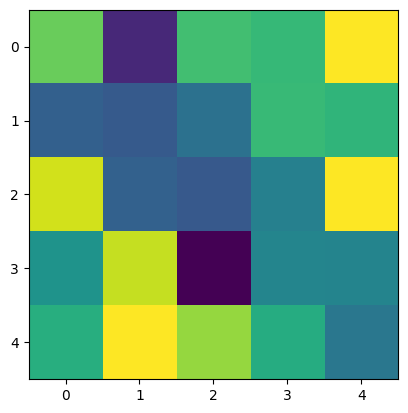

In [21]:
a = img1
for i in range(100):
    if i==99:
        plt.imshow(a)
        plt.show()
    a = a*alpha + (1-alpha)*np.random.randn(5, 5)

In [72]:
def gen_instance(_rng):
    def diffusion_step(x, _rng):
        noise = jax.random.normal(_rng, (5, 5))
        # x_nxt = x*alpha + (1-alpha)*noise
        x_nxt = x*np.sqrt(alpha) + np.sqrt(1-alpha)*noise
        return x_nxt, dict(img=x, noise=noise)

    idx = jax.random.randint(_rng, (), 0, len(dataset))
    x = dataset[idx]
    x, data = jax.lax.scan(diffusion_step, x, split(_rng, 1000))
    img, noise = data['img'], data['noise']
    return img, noise

rng = jax.random.PRNGKey(9)
img, noise = gen_instance(rng)

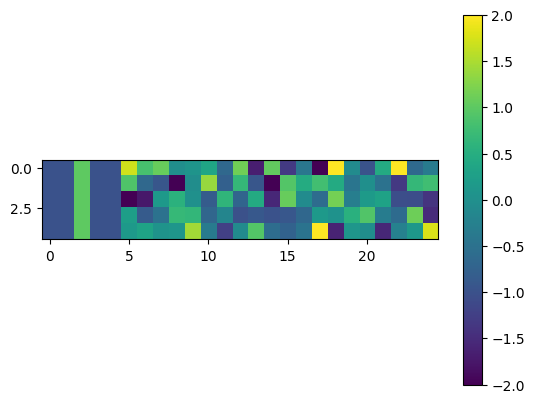

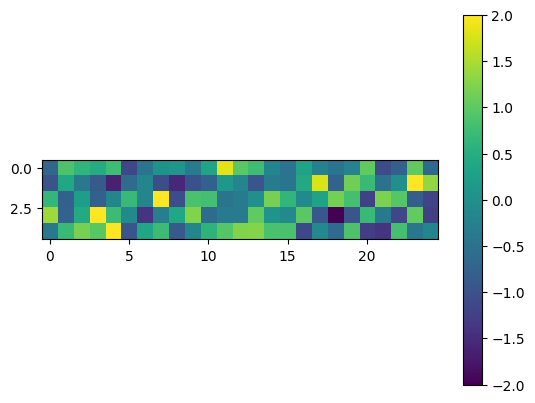

In [73]:
plt.imshow(rearrange(img[::200], 'C H W -> H (C W)'), vmin=-2, vmax=2)
plt.colorbar()
plt.show()
plt.imshow(rearrange(noise[::200], 'C H W -> H (C W)'), vmin=-2, vmax=2)
plt.colorbar()

In [ ]:
# predict the final image or the final noise given the the current timestep image...

In [ ]:
class Diffuser(nn.Module):
    pred_noise: bool = True
    @nn.compact
    def __call__(self, xin):
        H, W = x.shape
        x = xin.flatten()
        for _ in range(4):
            x = nn.Dense(features=H*W*3)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=H*W)(x)
        x = x.reshape(H, W)
        if self.pred_noise:
            return dict(noise=x, img=xin-x)
        else:
            return dict(noise=xin-x, img=x)

In [ ]:
diffuser = Diffuser()